In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Set the file path and load
file_path = '/content/drive/My Drive/Colab Notebooks/DAT 490 CAPSTONE/DataCoSupplyChainDatasetRefined.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Ensure relevant columns are in the right format
df['late_delivery_risk'] = df['late_delivery_risk'].astype(int)
df['delivery_time_diff'] = df['days_for_shipping_real'] - df['days_for_shipment_scheduled']

In [9]:
# Select relevant columns for store performance (adjust based on data)
store_features = ['late_delivery_risk', 'days_for_shipping_real', 'delivery_time_diff']

In [10]:
# Handle missing values by filling with median values
df[store_features] = df[store_features].fillna(df[store_features].median())

In [11]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[store_features])

In [12]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Try different cluster counts

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

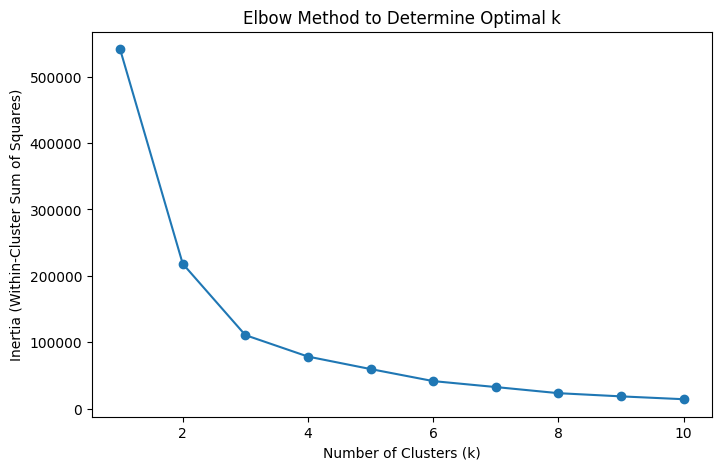

In [13]:
# Plot the Elbow Method graph
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [2]:
# Choose the best k (based on the Elbow Method) and apply K-Means clustering
optimal_k = 3  # Adjust based on the elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)

NameError: name 'KMeans' is not defined

In [ ]:
# Analyze the clusters
cluster_means = df.groupby('cluster')[store_features].mean()
print(cluster_means)

         late_delivery_risk  days_for_shipping_real  delivery_time_diff
cluster                                                                
0                  0.975878                5.349940            2.012539
1                  0.000000                2.722135           -0.773529
2                  1.000000                2.061098            1.000000


In [ ]:
# Sample a subset of the data for visualization
df_sample = df.sample(n=5000, random_state=42)

# Generate a pairplot with sampled data
sns.pairplot(df_sample, hue='cluster', diag_kind='kde', palette='viridis')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x79c6e7a60900> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79c6e79e5080> (for post_execute):


KeyboardInterrupt: 

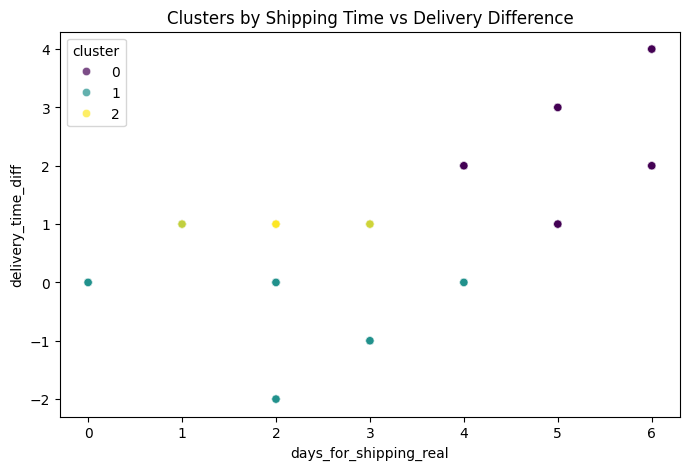

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_sample, x='days_for_shipping_real', y='delivery_time_diff', hue='cluster', palette='viridis', alpha=0.7)
plt.title("Clusters by Shipping Time vs Delivery Difference")
plt.show()

In [ ]:
# Count unique store locations using both latitude & longitude
total_unique_stores = df[['latitude_src', 'longitude_src']].drop_duplicates().shape[0]

print(f"Total number of unique stores: {total_unique_stores}")

Total number of unique stores: 11835


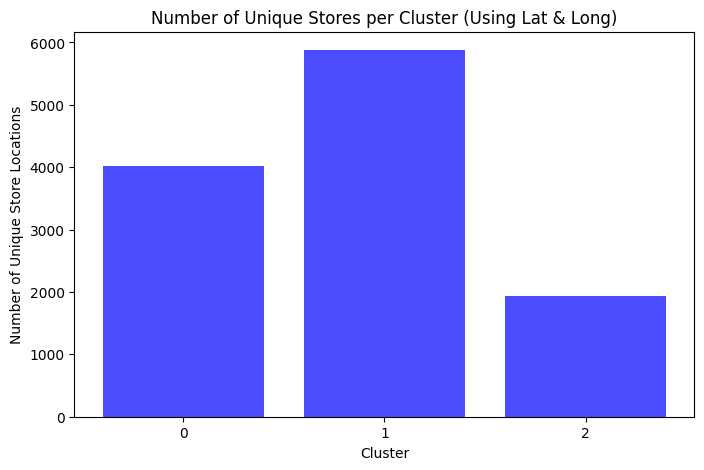

Sum of stores across clusters: 11835 (Should match 11835)


In [ ]:
import matplotlib.pyplot as plt

# Assign each store (lat/long) to its most frequent cluster
store_cluster_mapping = (
    df.groupby(['latitude_src', 'longitude_src'])['cluster']
    .agg(lambda x: x.value_counts().idxmax())  # Assign the most frequent cluster per store
    .reset_index()
)

# Count unique stores per cluster
store_counts_by_cluster = store_cluster_mapping['cluster'].value_counts().sort_index()

# Plot the corrected cluster distribution
plt.figure(figsize=(8,5))
plt.bar(store_counts_by_cluster.index, store_counts_by_cluster.values, color='blue', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Number of Unique Store Locations')
plt.title('Number of Unique Stores per Cluster (Using Lat & Long)')
plt.xticks(store_counts_by_cluster.index)
plt.show()

# Print the sum of unique stores across clusters to verify it matches total stores
print(f"Sum of stores across clusters: {store_counts_by_cluster.sum()} (Should match {total_unique_stores})")

<ipython-input-16-5b749651c2cb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df, palette='viridis')


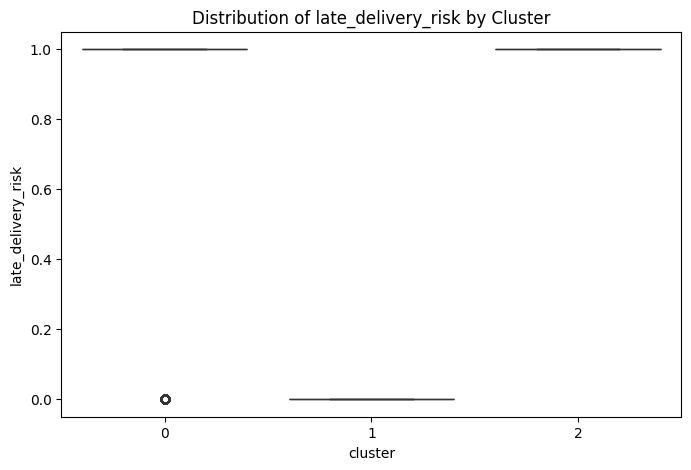

<ipython-input-16-5b749651c2cb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df, palette='viridis')


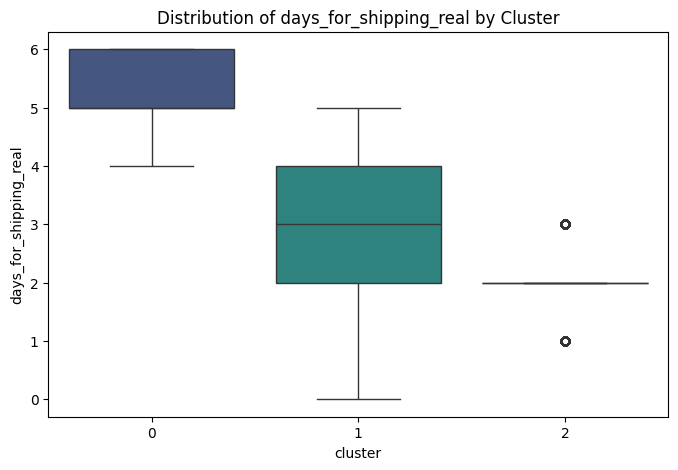

<ipython-input-16-5b749651c2cb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=feature, data=df, palette='viridis')


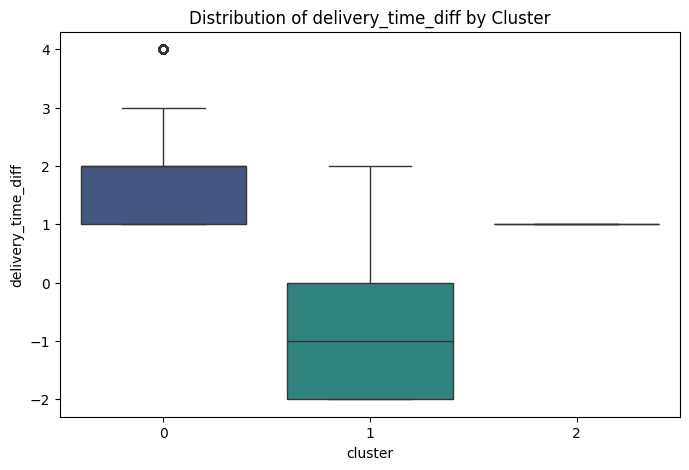

In [ ]:
import seaborn as sns

# Plot boxplots for each feature by cluster
for feature in store_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='cluster', y=feature, data=df, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

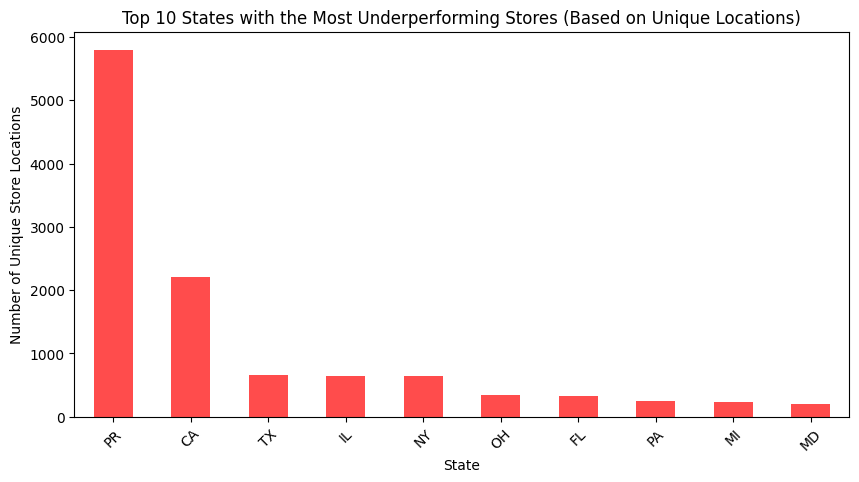

In [ ]:
import matplotlib.pyplot as plt

# Count unique store locations per state
underperforming_store_counts = (
    df[df['cluster'].isin([0, 2])]
    .groupby('customer_state')[['latitude_src', 'longitude_src']]
    .nunique()
    .sum(axis=1)  # Sum unique latitudes and longitudes as an approximation for unique stores
    .sort_values(ascending=False)
)

# Filter to the **Top 10 states**
top_10_states = underperforming_store_counts.head(10)

# Plot the corrected graph
plt.figure(figsize=(10,5))
top_10_states.plot(kind='bar', color='red', alpha=0.7)
plt.title('Top 10 States with the Most Underperforming Stores (Based on Unique Locations)')
plt.xlabel('State')
plt.ylabel('Number of Unique Store Locations')
plt.xticks(rotation=45)
plt.show()

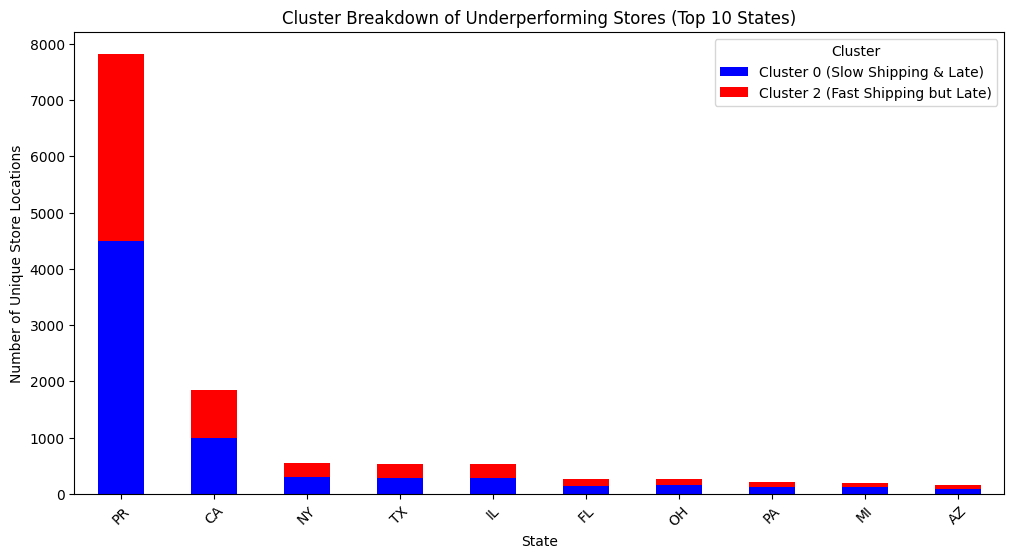

In [ ]:
import matplotlib.pyplot as plt

# Count unique store locations per state by cluster (using only latitude)
cluster_state_counts = (
    df[df['cluster'].isin([0, 2])]
    .groupby(['customer_state', 'cluster'])['latitude_src']
    .nunique()
    .unstack()  # Create separate columns for Cluster 0 and Cluster 2
    .fillna(0)  # Replace NaN values with 0
    .astype(int)  # Convert to integers
)

# Select the top 10 states with the most underperforming stores
top_10_states = cluster_state_counts.sum(axis=1).nlargest(10).index
filtered_cluster_counts = cluster_state_counts.loc[top_10_states]

# Plot the corrected stacked bar chart
filtered_cluster_counts.plot(kind='bar', stacked=True, figsize=(12,6), color=['blue', 'red'])
plt.title('Cluster Breakdown of Underperforming Stores (Top 10 States)')
plt.xlabel('State')
plt.ylabel('Number of Unique Store Locations')
plt.xticks(rotation=45)
plt.legend(title="Cluster", labels=["Cluster 0 (Slow Shipping & Late)", "Cluster 2 (Fast Shipping but Late)"])
plt.show()